In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report,roc_curve, roc_auc_score

data_set = pd.read_csv('heart-disease.csv')
data_set.tail()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0
302,57,0,1,130,236,0,0,174,0,0.0,1,1,2,0


In [2]:

data_set= data_set.drop_duplicates()# Retrait des valeurs dupliquées
#Mis à l'échelle des données avec la méthode Robust scaling pour éviter l'impact des valeurs aberrantes

X = data_set.drop(columns='target')  
y = data_set['target']       

In [3]:
# Division de l'ensemble de données en données d'entrainement et en données de test

X_entrainement, X_test, y_entrainement, y_test = train_test_split(X, y,test_size=0.2, random_state=0)
data_scaler_minmax = preprocessing.MinMaxScaler(feature_range=(0, 1)) 
X_scaled = data_scaler_minmax.fit_transform(X_entrainement)
X_entrainement =  pd.DataFrame(X_scaled, columns=X_entrainement.columns)
X_scaled_test =data_scaler_minmax.transform(X_test)
X_test =  pd.DataFrame(X_scaled_test, columns=X_test.columns)

In [4]:
# Modèle SVM par defaut
def_svc = SVC(random_state=42)
def_svc.fit(X_entrainement, y_entrainement)
print('Précision moyenne du modèle ( Support Vecteur Machine) : %f' % def_svc.score(X_test, y_test))

Précision moyenne du modèle ( Support Vecteur Machine) : 0.901639


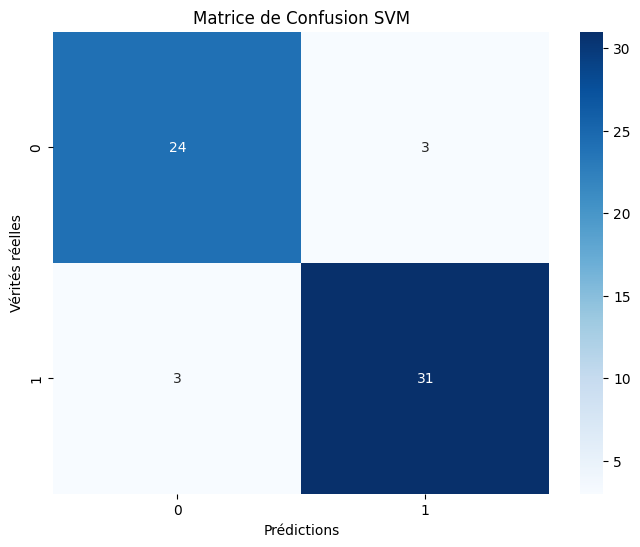

In [5]:
# predict and evaluate performance
def_y_pred = def_svc.predict(X_test)
matrice_confusion = confusion_matrix(y_test, def_y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(matrice_confusion, annot=True, fmt='d', cmap='Blues')

plt.title('Matrice de Confusion SVM')
plt.xlabel('Prédictions')
plt.ylabel('Vérités réelles')
plt.show()

In [13]:
exactitude = accuracy_score(y_test,def_y_pred)
precision = precision_score(y_test,def_y_pred)
rappel = recall_score(y_test,def_y_pred)
print(f" Exactitude : { exactitude *100: .2f}")
print(f" precision : { precision *100: .2f}")
print(f" rappel : { rappel*100: .2f}")


 Exactitude :  90.16
 precision :  91.18
 rappel :  91.18


In [14]:
rapport = classification_report(y_test, def_y_pred, target_names=['Absence de maladie', 'Présence de maladie'])
print(rapport)

                     precision    recall  f1-score   support

 Absence de maladie       0.89      0.89      0.89        27
Présence de maladie       0.91      0.91      0.91        34

           accuracy                           0.90        61
          macro avg       0.90      0.90      0.90        61
       weighted avg       0.90      0.90      0.90        61



In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import scipy
grid_parameters = {'kernel': ['linear', 'rbf'], 
 'gamma': [1e-3, 1e-4],
 'C': [1, 10, 50, 100]}

# perform hyperparameter tuning
print("# Tuning hyper-parameters for accuracy\n")
clf = GridSearchCV(SVC(random_state=42,probability=True), grid_parameters, cv=5, scoring='accuracy')
clf.fit(X_entrainement, y_entrainement)
# view accuracy scores for all the models
print("Grid scores for all the models based on CV:\n")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
 print("%0.5f (+/-%0.05f) for %r" % (mean, std * 2, params))
# check out best model performance
print("\nBest parameters set found on development set:", clf.best_params_)
print("Best model validation accuracy:", clf.best_score_)

# Tuning hyper-parameters for accuracy

Grid scores for all the models based on CV:

0.80119 (+/-0.09270) for {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}
0.53946 (+/-0.00884) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.80119 (+/-0.09270) for {'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}
0.53946 (+/-0.00884) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.82185 (+/-0.08246) for {'C': 10, 'gamma': 0.001, 'kernel': 'linear'}
0.75952 (+/-0.09109) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.82185 (+/-0.08246) for {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}
0.53946 (+/-0.00884) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.83852 (+/-0.08896) for {'C': 50, 'gamma': 0.001, 'kernel': 'linear'}
0.79277 (+/-0.08007) for {'C': 50, 'gamma': 0.001, 'kernel': 'rbf'}
0.83852 (+/-0.08896) for {'C': 50, 'gamma': 0.0001, 'kernel': 'linear'}
0.55170 (+/-0.04014) for {'C': 50, 'gamma': 0.0001, 'kernel': 'rbf'}
0.84269 (+/-0.09334) for {'C': 100, 'gamma': 0.001, 'kernel': 'linear'}
0.79286

In [17]:
gs_best = clf.best_estimator_
tuned_y_pred = gs_best.predict(X_test)
rapport = classification_report(y_test, tuned_y_pred, target_names=['Absence de maladie', 'Présence de maladie'])
print(rapport)


                     precision    recall  f1-score   support

 Absence de maladie       0.85      0.81      0.83        27
Présence de maladie       0.86      0.88      0.87        34

           accuracy                           0.85        61
          macro avg       0.85      0.85      0.85        61
       weighted avg       0.85      0.85      0.85        61



In [19]:
param_grid = {'C': scipy.stats.expon(scale=10), 
 'gamma': scipy.stats.expon(scale=.1),
 'kernel': ['rbf', 'linear']}
random_search = RandomizedSearchCV(SVC(random_state=42,probability=True), param_distributions=param_grid,
 n_iter=50, cv=5)
random_search.fit(X_entrainement, y_entrainement)
print("Best parameters set found on development set:")
random_search.best_params_

Best parameters set found on development set:


{'C': np.float64(65.69185828733679),
 'gamma': np.float64(0.06545232419711869),
 'kernel': 'linear'}

In [20]:
# get best model, predict and evaluate performance
rs_best = random_search.best_estimator_
rs_y_pred = rs_best.predict(X_test)
rapport = classification_report(y_test, rs_y_pred, target_names=['Absence de maladie', 'Présence de maladie'])
print(rapport)

                     precision    recall  f1-score   support

 Absence de maladie       0.85      0.81      0.83        27
Présence de maladie       0.86      0.88      0.87        34

           accuracy                           0.85        61
          macro avg       0.85      0.85      0.85        61
       weighted avg       0.85      0.85      0.85        61



In [22]:
exactitude = accuracy_score(y_test,rs_y_pred)
precision = precision_score(y_test,rs_y_pred)
rappel = recall_score(y_test,rs_y_pred)
print(f" Exactitude : { exactitude *100: .2f}")
print(f" precision : { precision *100: .2f}")
print(f" rappel : { rappel*100: .2f}")


 Exactitude :  85.25
 precision :  85.71
 rappel :  88.24


In [21]:
# Probabilités de la classe positive (présence de maladie)
y_probs = gs_best.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc = roc_auc_score(y_test, y_probs)
print(f'AUC : {auc:.2f}')


AUC : 0.90


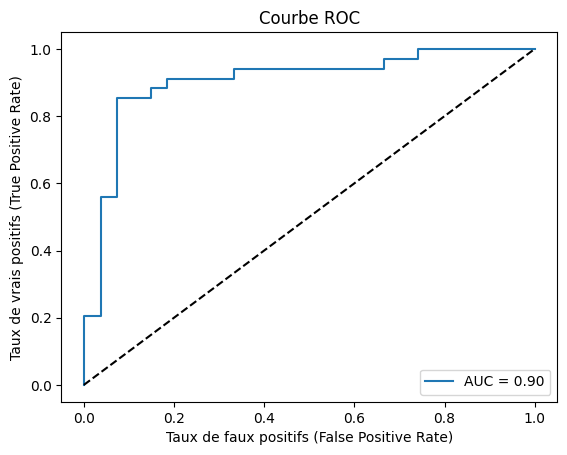

In [27]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Courbe aléatoire (ligne diagonale)
plt.xlabel('Taux de faux positifs (False Positive Rate)')
plt.ylabel('Taux de vrais positifs (True Positive Rate)')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

<Axes: xlabel='cp', ylabel='ca'>

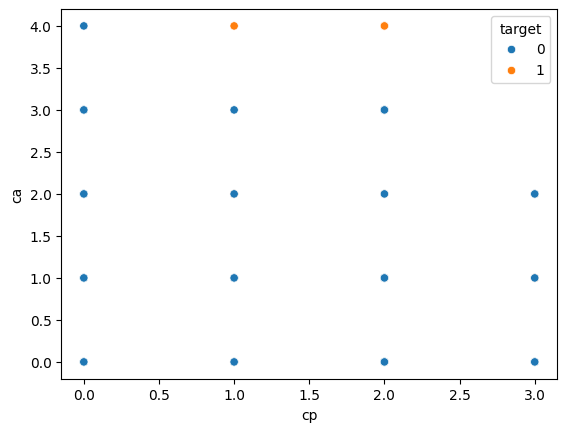

In [28]:
sns.scatterplot(x='cp',y='ca',hue='target',data=data_set)

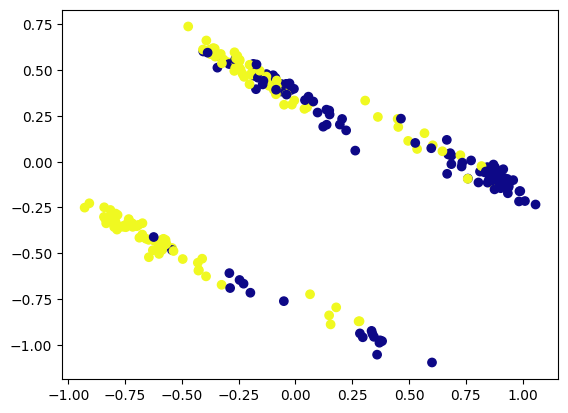

In [4]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
X_pca=pca.fit_transform(X_entrainement)
plt.scatter(X_pca[:,0],X_pca[:,1],c=y_entrainement,cmap='plasma',label=y_entrainement)

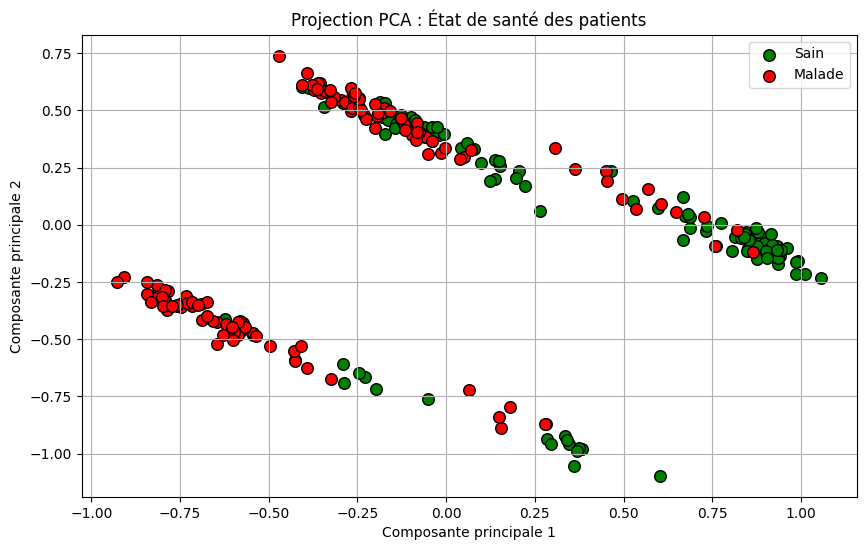

In [5]:
class_healthy = y_entrainement == 0  # Classe Sain
class_sick = y_entrainement == 1    # Classe Malade

# Visualisation des données projetées
plt.figure(figsize=(10, 6))  # Taille du graphique
plt.scatter(X_pca[class_healthy, 0], X_pca[class_healthy, 1], 
            color='green', label='Sain', edgecolor='k', s=70)
plt.scatter(X_pca[class_sick, 0], X_pca[class_sick, 1], 
            color='red', label='Malade', edgecolor='k', s=70)

# Ajout de titre, légende et axes
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.title("Projection PCA : État de santé des patients")
plt.legend()  # Affiche les labels Sain/Malade
plt.grid(True)  # Optionnel : ajoute une grille
plt.show()